In [1]:
from pathlib import Path
import pickle
import numpy as np
from lsst.daf.persistence import Butler
import lsst.afw.display as afwDisplay
import matplotlib.pyplot as plt
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable
from astropy.io import fits
plt.style.use('seaborn-poster')

In [4]:
from scipy.ndimage.interpolation import rotate

Identify the single exposure warp that gives rise to the satellite streak that appears in the coadd

(15899.5, 20099.5, 31899.5, 35999.5)

<Figure size 921.6x633.6 with 0 Axes>

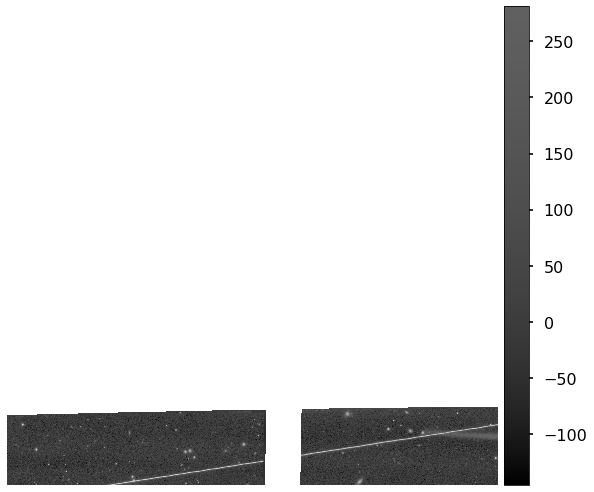

In [3]:
butler = Butler("/datasets/hsc/repo/rerun/RC/v21_0_0_rc1/DM-27597")
deepCoadd = butler.get("deepCoadd_directWarp", dataId={"tract":9813, "filter":"HSC-I", "patch":'4,8', 'visit':1246})

for maskName, maskBit in deepCoadd.mask.getMaskPlaneDict().items():
    if maskName == 'DETECTED' or maskName == 'CLIPPED' or maskName == 'STREAK':
        pass
    else:
        deepCoadd.getMask().clearMaskPlane(maskBit)
afwDisplay.setDefaultBackend('matplotlib')
plt.figure()
afw_display = afwDisplay.Display()
#afw_display.setMaskPlaneColor('CLIPPED','green')
#afw_display.setMaskPlaneColor('STREAK','red')
afw_display.setMaskTransparency(100)
afw_display.scale('asinh', 'zscale')
afw_display.mtv(deepCoadd)
plt.gca().axis('off')

Now in the terminal run the following code to create a coadd with morpholoical filtering. This will catch the satellite streak and mask it out. The default coadditon process does not catch this streak.

assembleCoadd.py --warpCompareCoadd DM-27597 --output /home/ishasan/otherStarlink/ --selectId filter=HSC-I --id filter=HSC-I tract=9813 patch=4,8 --config doFilterMorphological=True --clobber-versions --clobber-config

In [3]:
doMorphCoadd = afwImage.exposure.ExposureF.readFits('../otherStarlink/deepCoadd/HSC-I/9813/4,8.fits')
deepCoadd = butler.get("deepCoadd", dataId={"tract":9813, "filter":"HSC-I", "patch":'4,8', 'visit':1246})

Plot the difference between the default coadd and the coadd with morphological filtering turned on. This residual image will show the satellite streak

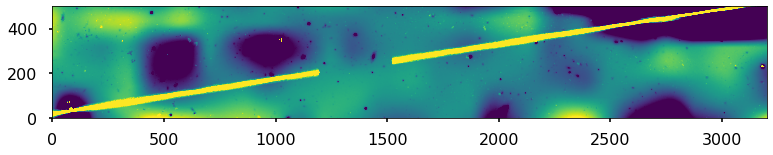

In [5]:
plt.imshow((deepCoadd.getImage().array - doMorphCoadd.getImage().array)[:500,1000:],
           vmin=-0.01, vmax=0.01, origin='lower')

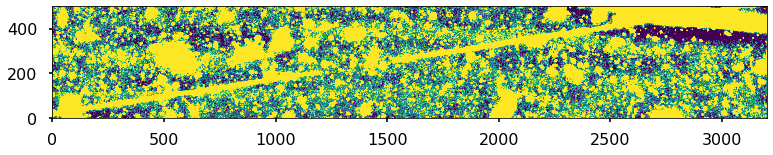

In [7]:
plt.imshow((deepCoadd.getImage().array)[:500,1000:],
           vmin=-0.01, vmax=0.01, origin='lower')

Now we will make a number of different coadds with morphological filtering, where we will adjust the mask width. 

assembleCoadd.py --warpCompareCoadd DM-27597 --output /home/ishasan/otherStarlink/ --selectId filter=HSC-I --id filter=HSC-I tract=9813 patch=4,8 --config doFilterMorphological=True maskStreaks.footprintThreshold=.1 --clobber-versions --clobber-config

Also do this for the following footprintThreshold values: .5, .7, 1.5, 1, 2, 3, 4, 5, 6, 7, 8. Rename each of the coadds to 4,8-footprintThresholdj.fits where j is the value of footprintThreshold. This will prevent overwriting the coadds

In [7]:
import matplotlib.colors as colors
plt.rcParams['xtick.minor.visible'] = True
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

In [2]:
def plotProfile(path):
    doMorphCoadd = afwImage.exposure.ExposureF.readFits('../otherStarlink/deepCoadd/HSC-I/9813/4,8-noStreak.fits')
    masked = afwImage.exposure.ExposureF.readFits(path)
    diffim = (masked.getImage().array - doMorphCoadd.getImage().array)[:500,1000:]
    rotim = rotate(diffim,8.5)
    fooim = rotim[400:600,200:1200]
    f, ax = plt.subplots(nrows=2)
    
    ax[0].plot(np.arange(0,200,1)*.168, fooim.mean(axis=1)*57.544)
    ax[0].set_xlabel('arcseconds')
    ax[0].set_ylabel("nJy/pixel")
#    ax[0].set_yscale('log')
#    ax[0].set_ylim([1e-3,2])
#    ax[0].set_ylim([-.01,2])
#    ax[0].xaxis.set_minor_locator(MultipleLocator(5))
    ax[1].imshow(fooim, origin='lower', vmin=-.01, vmax=.01)
    arcsec_label = [0,10,20,30]
    position = [i/.168 for i in arcsec_label]

    ax[1].set_yticks(position)
    ax[1].set_yticklabels(arcsec_label)

    ax[1].tick_params(
        axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        top=False,         # ticks along the top edge are off
        labelbottom=False)
    ax[1].set_ylabel('arcseconds')
#    print((fooim + 0.038476).sum()*57.544)
#    print(np.sqrt((fooim + 0.038476).sum())*57.544)
    print((fooim).sum()*57.544)
    print(np.sqrt((fooim).sum())*57.544) #the 57.544 changes units to nJy
    return

743.1951907806396
206.80045122528074


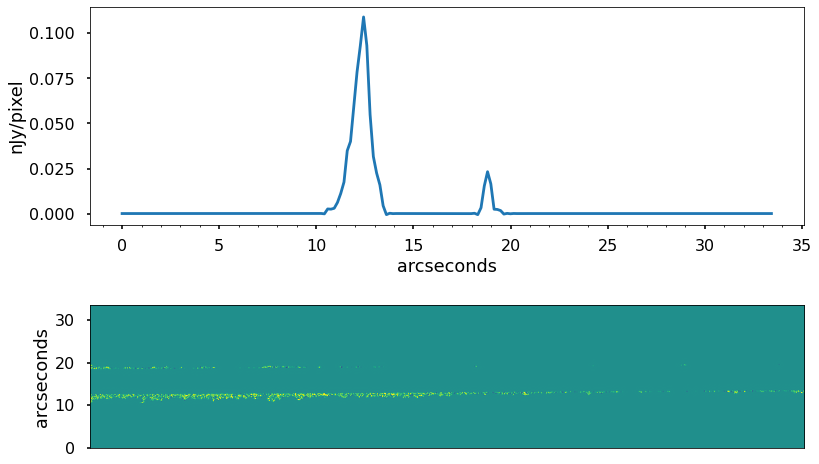

In [9]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold.1.fits')

3744.3788428955077
464.183708114624


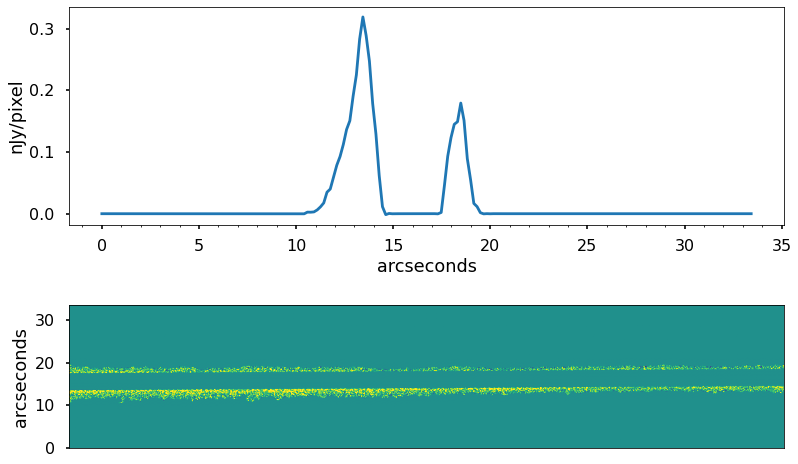

In [8]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold.5.fits')

4793.109374572754
525.1806466522216


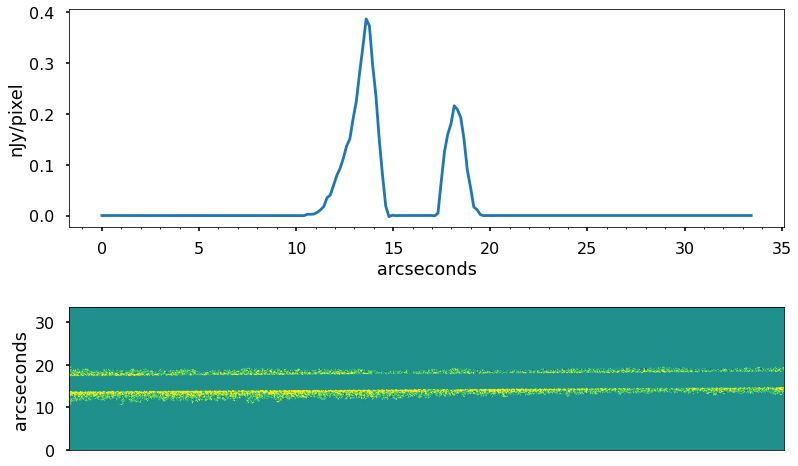

In [16]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold.7.fits')

6157.736148132324
595.265311126709


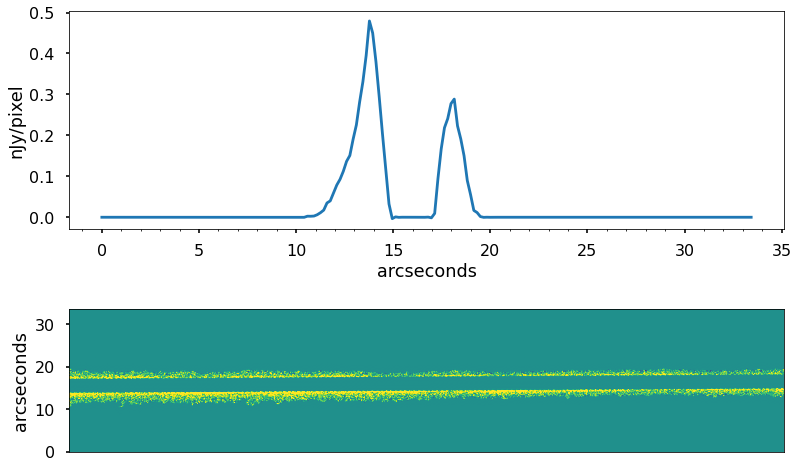

In [10]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold1.fits')

452717.75440624997
5104.036721557617


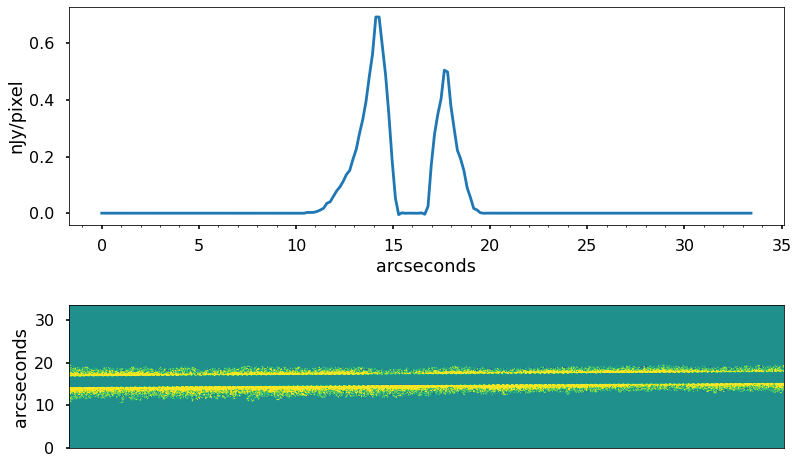

In [50]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold2.fits')

456264.77443359373
5123.9926428833005


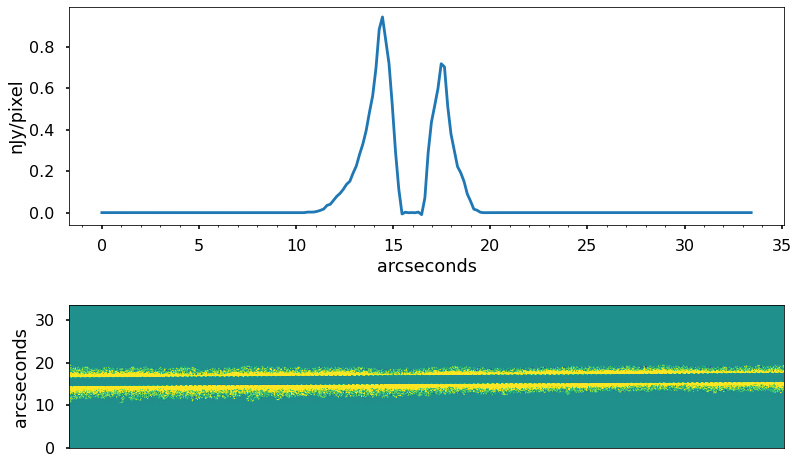

In [51]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold3.fits')

460013.11416796874
5144.996958007812


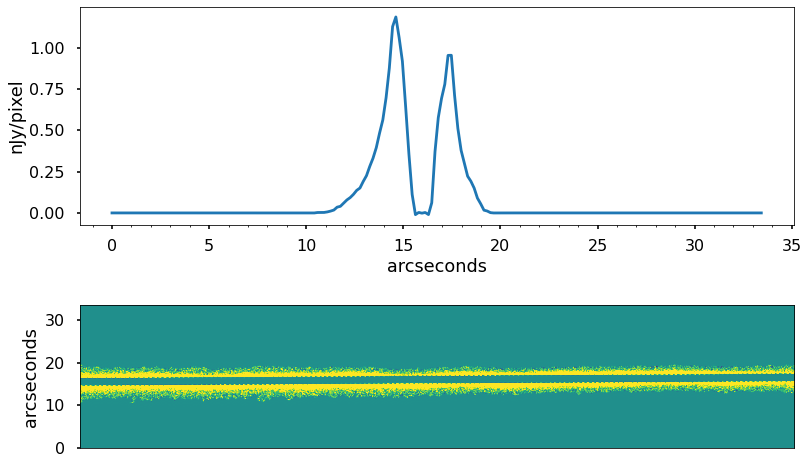

In [52]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold4.fits')

464192.19097265624
5168.314500488281


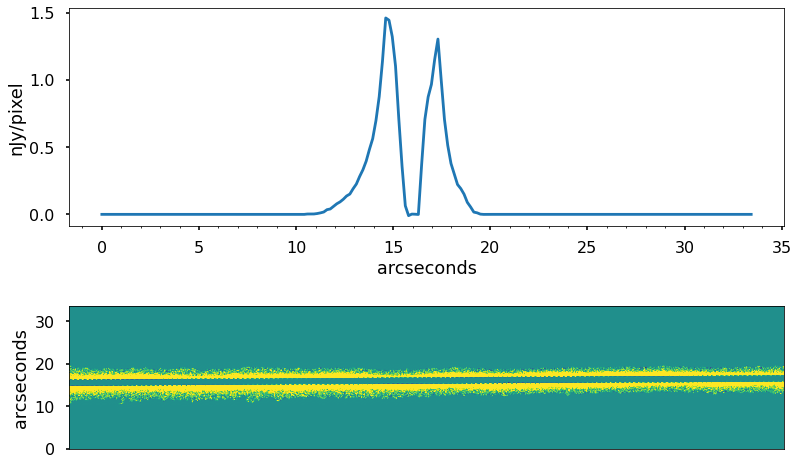

In [53]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold5.fits')

assembleCoadd.py --warpCompareCoadd DM-27597 --output /home/ishasan/otherStarlink/ --selectId filter=HSC-I --id filter=HSC-I tract=9813 patch=4,8 --config doFilterMorphological=True maskStreaks.footprintThreshold=6 --clobber-versions --clobber-config

469085.2854179687
5195.483177978515


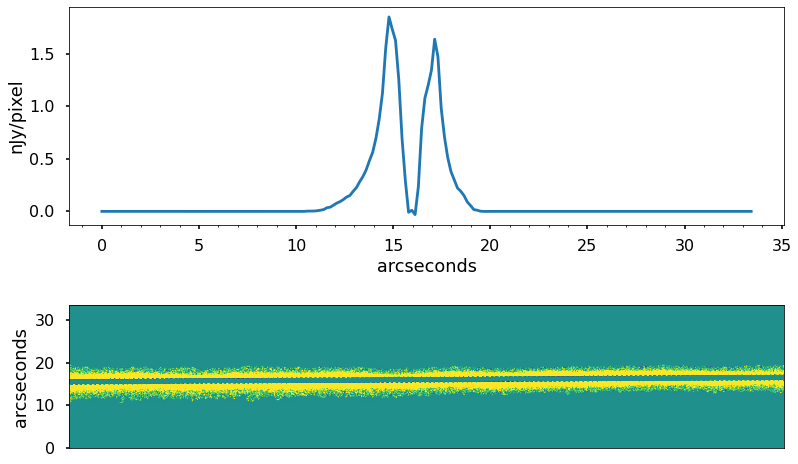

In [54]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold6.fits')

32233.592615722653
1361.9287400207518


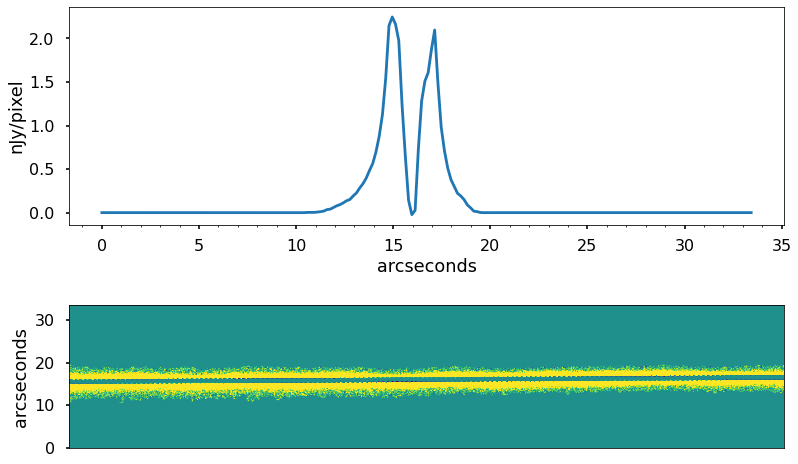

In [13]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold7.fits')

In [19]:
plotProfile('../otherStarlink/deepCoadd/HSC-I/9813/4,8-footprintThreshold8.fits')

<IPython.core.display.Javascript object>

482567.07474218745
5269.61489276123


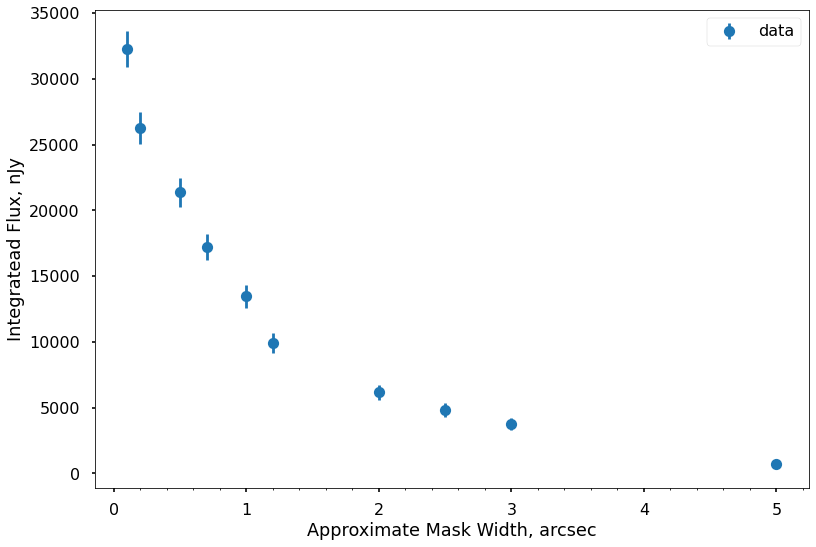

In [18]:
x_model = np.arange(.2, 5.2, .2)
xprime = [5, 3, 2.5, 2, 1.2, 1, .7, .5, .2, .1]
y = [743.19, 3744.37,4793.10, 6157.73, 9905.22, 13452.23, 17200.56, 21379.66, 26272.73, 32233.59]
yerr = [206.800,464.183, 525.180, 595.264, 754.974, 879.827, 994.881, 1109.175, 1229.568, 1361.92]

#y = [443555.726, 448970.257, 452717.7544, 456264.774, 460013.114, 464192.1909, 469085.285, 475046.118, 482567.074]
#yerr = [5052.125, 5082.867, 5104.036, 5123.992, 5144.996, 5168.314, 5195.483, 5228.389, 5269.614]

from scipy.optimize import curve_fit
def exponential(x, a, b):
    return a*np.exp(b*x)

pars, cov = curve_fit(f=exponential, xdata=xprime, ydata=y, p0=[1, 1])

ypred = exponential(x_model, pars[0], pars[1])

plt.errorbar(xprime, y, label='data', yerr=yerr, fmt='o')
#plt.plot(x_model, ypred, color='C0', label='best fit exponential')
plt.xlabel('Approximate Mask Width, arcsec')
plt.ylabel('Integratead Flux, nJy')
plt.legend()